# Adults Census Model Training with Sagemaker
## Scikit-learn: Decision Tree Algorithm

This notebook used to experiment Scikit-learn with Sagemaker by utilizing the pre-built container.

[Analysis](#compaire)

- **Performance metrics for Local and sagemaker training hardware are equal.**


## Outline

1. [Setup Development Environment](#setup)
2. [Data Preparation](#data_prep)
3. [Model Training](#train)
4. [Model Comparison](#compaire)
5. [Adversarially train a robust classifier](#adv_training)

<a id="setup"></a>
### 1 Set up Development Environment

Steps:
- Import base Amazon SageMaker ML packages
- Check the SDK version
- Create S3 bucket

In [1]:
# base packages to work with SageMaker
import boto3
from sagemaker import get_execution_role
import sagemaker

# check core SDK version number
print("Ready to use Amazon SageMaker", sagemaker.__version__)

Ready to use Amazon SageMaker 2.16.4.dev0


In [2]:
# S3 prefix
prefix = 'Scikit-adults'

# Now let's define the S3 bucket
sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
print(f'Using S3 bucket: {bucket}' )

Using S3 bucket: sagemaker-us-east-2-359732627051


In [3]:
# Python libraries that we'll use throughout the analysis
import os
import datetime
import time
import tarfile
import pandas as pd
import numpy as np

<a id="data_prep"></a>
### 2. Data Preparation
We download Adult Census Income Binary classfication dataset from github, prepreocessing, split it and send it to S3

- 2.1 Download dataset
- 2.2 Upload data to Amazon S3 bucket

Dataset: https://archive.ics.uci.edu/ml/datasets/Adult

**Ref:  Exp-2_train_adult_SVC_SageMaker-v3.ipynb**


<a id="train"></a>
### 3 Model Training

- 3.1 [Prepare a training script](#3_1)
- 3.2 [Train Model](#3_2)
    - 3.2.1 [Run locally](#3_2_1)
    - 3.2.2 [Submit the Training Job to the Compute Cluster](#3_2_2)
    - 3.2.3 [Run locally (My Desktop hardware)](#3_2_3)
        - 3.2.3.1 [Setup](#3_2_3_1)
        - 3.2.3.2 [Data Preparation](#3_2_3_2)
        - 3.2.3.3 [Model Training](#3_2_3_3)

<a id="3_1"></a>
#### 3.1 Prepare a training script
The below script contains training model and can run (model training) both in SageMaker hardware for model training or locally (desktop, SageMaker notebook, etc)

In [4]:
# Directory to write training script.
# Code Directory
import os
script_folder = os.path.join(os.getcwd(), "script")
os.makedirs(script_folder, exist_ok=True)

In [5]:
%%writefile $script_folder/train_adult_CART.py
import os
import time
import argparse
import joblib
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier


if __name__ =='__main__':
    
    start_time = time.time()
    
    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # hyperparameters will be passed as arguments to the script.
    # example: sklearn DecisionTreeClassifier hyperparameters
    parser.add_argument('--max-leaf-nodes', type=int, default=30)
    
    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--features', type=str)  # required name features for flexibity
    parser.add_argument('--target', type=str, default='IncomeGroup')

    args, _ = parser.parse_known_args()
    print(f"--model-dir: {args.model_dir}")
    print(f"--train: {args.train}")
    
    # Take the set of files and read them all into a single pandas dataframe
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) ]
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
    raw_data = [ pd.read_csv(file, engine="python") for file in input_files ]
    df = pd.concat(raw_data)
    print(df.head())
          
    #Prepocessing
    print('building datasets')
    X = df[args.features.split()]
    y = df[args.target]

    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    print(f"cat_ix: {cat_ix}")
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    print(f"num_ix: {num_ix}")
    
    #use stratify for un balanced number of examples for each class label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)
    print(f"X_train:{X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train:{y_train.shape}")
    print(f"y_test: {y_test.shape}")
          
    # Model Training: Support Vector Machines
    print('training model')
    MODEL = 'CART'
    # define steps
    model = DecisionTreeClassifier(max_leaf_nodes=args.max_leaf_nodes, random_state=42)
    
    steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer(steps)
    # wrap the model a pipeline
    pipe  = Pipeline(steps=[('transformer',ct),('cart',model)])
    pipe.fit(X_train, y_train)
    print(f"model: {pipe}")
          
    ## Evaluate the model

    # using threshold
    threshold = 0.5 # set threshold as 0.5
    y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int) 
    print(f"y_pred: {y_pred}")
    print(f'Misclassified examples:{(y_test != y_pred).sum()}')
    print(pipe.predict_proba(X_test))
          
    print(f"distinct y_pred: {np.unique(y_pred)}")
    print(f"distinct y_test: {np.unique(y_test)}")
          
    # Confusion Matrix
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    print(f"confusion matrix:\n {conf_mat}")
    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f"auc: {auc}")
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}") 
    
    # Precision
    precision = metrics.precision_score(y_test, y_pred)
    print(f"Precision: {precision}")
    
    # Recall
    recall = metrics.recall_score(y_test, y_pred)
    print(f"Recall: {recall}")
    
    # F1
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"F1: {f1}")
    
    # classification_report
    print('classification_report')
    print(metrics.classification_report(y_test, y_pred))
        
    # persist model
    path = os.path.join(args.model_dir, f"{MODEL}.joblib")
    joblib.dump(pipe, path)
    print('model persisted at ' + path)
    
    time_elapsed = (time.time() - start_time)
    print("Computational time:{}".format(time_elapsed))

Writing /home/ec2-user/SageMaker/script/train_adult_CART.py


<a id="3_2"></a>
#### 3.2 Train Model

- 3.2.1 [Run locally](#3_2_1)
- 3.2.2 [Submit the Training Job to the Compute Cluster](#3_2_2)
- 3.2.3 [Run locally (My Desktop hardware)](#3_2_3)



<a id="3_2_1"></a>
##### 3.2.1 Run locally
Here we can run model Training locally (such as desktop, SageMaker notebook, etc)

script arguments allows us to remove from the script any SageMaker-specific configuration, and run locally

In [8]:
#! pip install watermark
%reload_ext watermark
%watermark

2020-12-07T21:30:56+00:00

CPython 3.6.10
IPython 7.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.14.200-116.320.amzn1.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


In [9]:
%reload_ext watermark
%watermark  -d -u -a "SageMaker Notebook Instance" -v -p numpy,pandas,scipy,sagemaker,sklearn

SageMaker Notebook Instance 
last updated: 2020-12-07 

CPython 3.6.10
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
scipy 1.4.1
sagemaker 2.16.4.dev0
sklearn 0.22.1


--features 'age fnlwgt education education-num marital-status relationship race sex capital-gain capital-loss hours-per-week' 

In [6]:
! python $script_folder/train_adult_CART.py --max-leaf-nodes 30 \
                   --model-dir ./ \
                   --train ./data/ \
                   --features 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'

extracting arguments
--model-dir: ./
--train: ./data/
   age          workclass  fnlwgt  ... hours-per-week  native-country IncomeGroup
0   39          State-gov   77516  ...             40   United-States       <=50K
1   50   Self-emp-not-inc   83311  ...             13   United-States       <=50K
2   38            Private  215646  ...             40   United-States       <=50K
3   53            Private  234721  ...             40   United-States       <=50K
4   28            Private  338409  ...             40            Cuba       <=50K

[5 rows x 15 columns]
building datasets
cat_ix: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')
num_ix: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
X_train:(31655, 14)
X_test: (13567, 14)
y_train:(31655,)
y_test: (13567,)
training model
model: Pipeline(memory=None,
         steps

<a id="3_2_2"></a>
##### 3.2.2 Submit the Training Job to the Compute Cluster
Here we can run model Training in SageMaker training hardware.
- Training job will show up in the Amazon SageMaker under Training section.
- Launching a training job with the Python SDK
- Create a sagemaker.sklearn.SKLearn Estimator

In [10]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

sklearn_estimator = SKLearn(
    source_dir="./script/",
    entry_point='train_adult_CART.py',
    role = get_execution_role(),
    instance_type='ml.m5.4xlarge', 
    framework_version='0.20.0',
    base_job_name='binary-classifiation-scikit-cart',
    hyperparameters = {'max-leaf-nodes': 30,
                       'features': 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
                      })

###### Call the estimator’s fit method

In [11]:
train_input = 's3://sagemaker-us-east-2-359732627051/Scikit-adults/data'
train_input

's3://sagemaker-us-east-2-359732627051/Scikit-adults/data'

In [12]:
# launch training job, with asynchronous call
sklearn_estimator.fit({'train': train_input}, wait=False)

<a id="3_2_3"></a>
##### 3.2.3 Run locally (My Desktop hardware)
Here we can run model Training locally use my desktop hardware:

- 3.2.3.1 [Setup](#3_2_3_1)
- 3.2.3.2 [Data Preparation](#3_2_3_2)
- 3.2.3.3 [Model Training](#3_2_3_3)

<a id="3_2_3_1"></a>
###### 3.2.3.1 Setup

In [17]:
#! pip install watermark
%reload_ext watermark
%watermark  -d -u -h -m -a "Habtamu desalegn" -v -p numpy,pandas,scipy,sklearn

Author: Habtamu desalegn

Last updated: 2020-12-10

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.19.0

numpy  : 1.19.4
pandas : 1.1.4
scipy  : 1.5.3
sklearn: 0.23.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 7
Machine     : AMD64
Processor   : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores   : 4
Architecture: 64bit

Hostname: Hade-PC



In [12]:
# Python libraries 
import os
import time
import collections
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

<a id="3_2_3_2"></a>
###### 3.2.3.2 Data Preparation

**Reference: Exp-2_train_adult_SVC_SageMaker-v3.ipynb**

<a id="3_2_3_3"></a>
###### 3.2.3.3 Model Training

In [13]:
start_time = time.time()

df = pd.read_csv("./data/adult.csv")
df.head()
        
#Prepocessing

print('building datasets')
features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
target = 'IncomeGroup'
X = df[features.split()]
y = df[target]

# label encode the target variable to have the classes 0 and 1
y = LabelEncoder().fit_transform(y)

cat_ix = X.select_dtypes(include=['object', 'bool']).columns
print(f"cat_ix: {cat_ix}")
num_ix = X.select_dtypes(include=['int64', 'float64']).columns
print(f"num_ix: {num_ix}")

#use stratify for un balanced number of examples for each class label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)
print(f"X_train:{X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train:{y_train.shape}")
print(f"y_test: {y_test.shape}")

# Model Training: DecisionTreeClassifier
print('training model')
MODEL = 'CART'
# define steps
model = DecisionTreeClassifier(max_leaf_nodes=30, random_state=42)
    
steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
# one hot encode categorical, normalize numerical
ct = ColumnTransformer(steps)
# wrap the model a pipeline
pipe  = Pipeline(steps=[('transformer',ct),('cart',model)])
pipe.fit(X_train, y_train)
print(f"model: {pipe}")
  
## Evaluate the model
# using threshold
threshold = 0.5 # set threshold as 0.5
y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int) 
print(f"y_pred: {y_pred}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')
print(pipe.predict_proba(X_test))
  
print(f"distinct y_pred: {np.unique(y_pred)}")
print(f"distinct y_test: {np.unique(y_test)}")
  
# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 

# Precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1
f1 = metrics.f1_score(y_test, y_pred)
print(f"F1: {f1}")

# classification_report
print('classification_report')
print(metrics.classification_report(y_test, y_pred))

# persist model
path = f"models/SageMaker/Adult/local/desktop/{MODEL}.joblib"
joblib.dump(pipe, path)
print('model persisted at ' + path)

time_elapsed = (time.time() - start_time)
print("Computational time:{}".format(time_elapsed))

building datasets
cat_ix: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')
num_ix: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
X_train:(31655, 14)
X_test: (13567, 14)
y_train:(31655,)
y_test: (13567,)
training model
model: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('c',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('n', MinMaxScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype=

<a id="compaire"></a>
### 4 Model Comparison


<a id="result"></a>
Note: **similar**

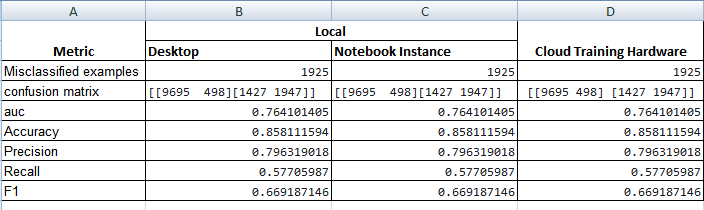

In [16]:
from IPython.display import Image

Image(filename='images/SageMaker/Exp-2/CART/metric-compair.png')

#### some screenshots from SageMaker Training hardware

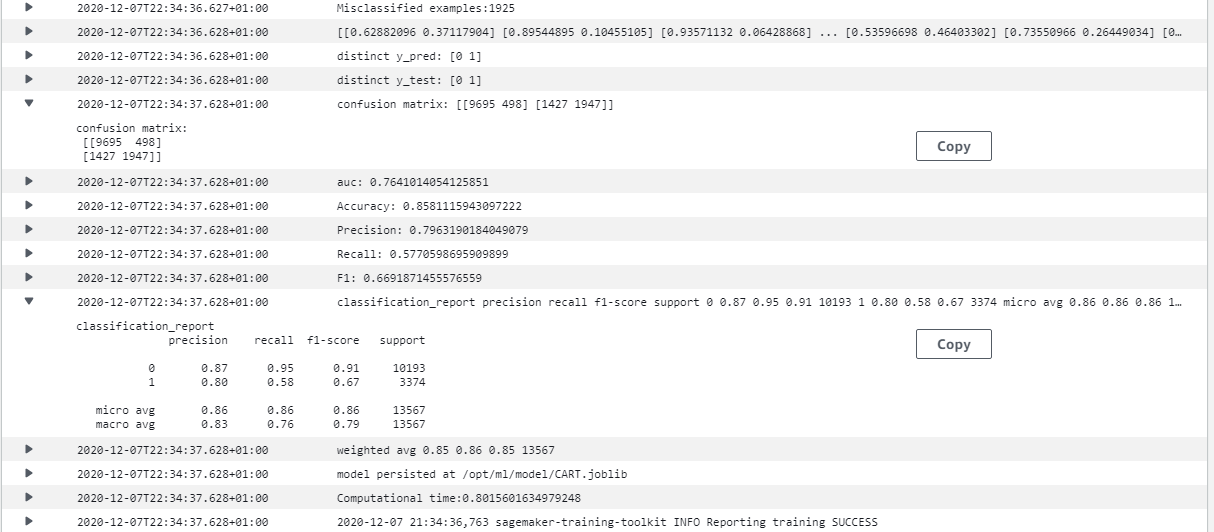

In [14]:
Image(filename='images/SageMaker/Exp-2/CART/metric.png')

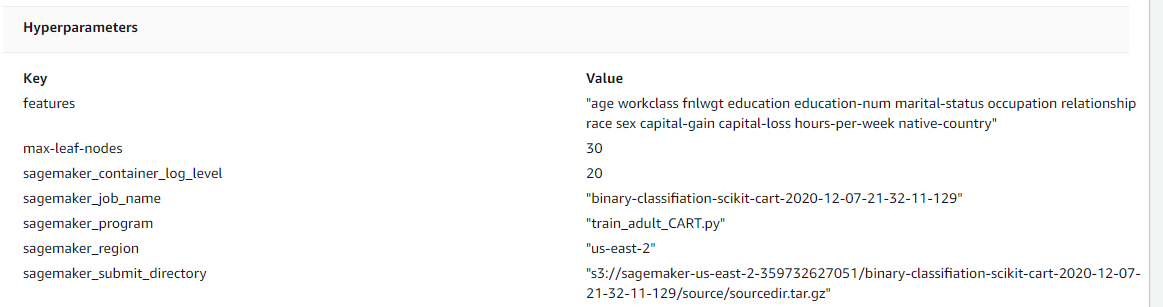

In [15]:
Image(filename='images/SageMaker/Exp-2/CART/hyperparameter.png')

<a id="adv_training"></a>
### 5. Adversarially train a robust classifier

Adversarial-Robustness-Toolbox for scikit-learn DecisionTree

In [3]:
#!pip install tqdm

In [4]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack

##### Prepare dataset

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## read the data
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header = None, na_values=' ?')
## read test data
data_test = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", header = None, skiprows=1, na_values=' ?')

## set column names
data.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'IncomeGroup']
data_test.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'IncomeGroup']

# preprocess

d = {' <=50K': 0,
     ' >50K': 1}
data['IncomeGroup'] = data['IncomeGroup'].map(d)

t = {' <=50K.': 0,
     ' >50K.': 1}
data_test['IncomeGroup'] = data_test['IncomeGroup'].map(t)

# Combine the two datasets to convert the categorical values to binary indicators
data_combined = pd.concat([data, data_test])
c = {0 : ' <=50K',
     1 : ' >50K'}
data_combined['IncomeGroup'] = data_combined['IncomeGroup'].map(c)
print(f"data_combined.shape: {data_combined.shape}")

# drop rows with missing
data_combined = data_combined.dropna()
print(f"data_combined.shape (After dropna): {data_combined.shape}")

# display data
print(f"shape:{data_combined.shape}")

le = LabelEncoder()

new_df = data_combined.loc[:, ~data_combined.columns.isin(['workclass','occupation','native-country'])]
new_df.loc[:,'education'] = le.fit_transform(new_df.loc[:,'education'].values)
new_df.loc[:,'marital-status'] = le.fit_transform(new_df.loc[:,'marital-status'].values)
new_df.loc[:,'relationship'] = le.fit_transform(new_df.loc[:,'relationship'].values)
new_df.loc[:,'race'] = le.fit_transform(new_df.loc[:,'race'].values)
new_df.loc[:,'sex'] = le.fit_transform(new_df.loc[:,'sex'].values)
new_df.loc[:,'IncomeGroup'] = le.fit_transform(new_df.loc[:,'IncomeGroup'].values)

X = new_df.drop('IncomeGroup', axis=1).values
y = new_df['IncomeGroup'].values

#use stratify for un balanced number of examples for each class label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)
print(f"X_train:{X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train:{y_train.shape}")
print(f"y_test: {y_test.shape}")


data_combined.shape: (48842, 15)
data_combined.shape (After dropna): (45222, 15)
shape:(45222, 15)
X_train:(31655, 11)
X_test: (13567, 11)
y_train:(31655,)
y_test: (13567,)


C:\Users\Hade\.conda\envs\azml\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### 1. Train DecisionTreeClassifier classifier

In [40]:
model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=50, min_impurity_decrease=0.0, 
                               min_impurity_split=None, class_weight=None)

In [41]:
model.fit(X=X_train, y=y_train)

DecisionTreeClassifier(max_leaf_nodes=50)

#### 2. Create and apply Zeroth Order Optimization Attack with ART

In [42]:
# Create ART classifier for scikit-learn DecisionTreeClassifier
art_classifier = SklearnClassifier(model=model)

In [43]:
# from art.attacks.evasion import ZooAttack
# Create ART Zeroth Order Optimization attack
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

In [44]:
# Generate adversarial samples with ART Zeroth Order Optimization attack
x_train_adv = zoo.generate(X_train)

ZOO: 100%|████████████████████████████████████████████████████████████████████████████████████| 31655/31655 [1:55:54<00:00,  4.55it/s]


In [45]:
# Generate adversarial samples with ART Zeroth Order Optimization attack
x_test_adv = zoo.generate(X_test)

ZOO: 100%|██████████████████████████████████████████████████████████████████████████████████████| 13567/13567 [49:50<00:00,  4.54it/s]


#### 3. Evaluate DecisionTreeClassifier on benign and adversarial samples

In [46]:
## evaluate performance on those:
# Training score on Benign
score = model.score(X_train, y_train)
print("Benign Training Score: %.4f" % score)

# Training Predict
prediction = model.predict(X_train[0:5, :])
print(f"Benign Training Predicted Label: {prediction}")

# Training score on Adversarial
score_adv = model.score(X_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score_adv)

prediction_adv = model.predict(X_train_adv[0:5, :])
print(f"Adversarial Training Predicted Label: {prediction_adv}")

Benign Training Score: 0.8546
Benign Training Predicted Label: [0 0 0 0 0]
Adversarial Training Score: 0.8546
Adversarial Training Predicted Label: [0 0 0 0 0]


In [47]:
##### Test score
score = model.score(X_test, y_test)
print("Benign Test Score: %.4f" % score)

prediction = model.predict(X_test[:5, :])
print(f"Benign Test Predicted Label: {prediction}")

score = model.score(X_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

prediction = model.predict(X_test_adv[0:5, :])
print(f"Adversarial Test Predicted Label: {prediction}")

Benign Test Score: 0.8520
Benign Test Predicted Label: [0 0 0 0 1]
Adversarial Test Score: 0.8520
Adversarial Test Predicted Label: [0 0 0 0 1]


In [48]:
print("X_Train")
print(X_train[0:5, :])
print("X_Train_adv")
print(X_train_adv[0:5, :])

X_Train
[[    20 250165     11      9      2      0      4      1      0      0
      40]
 [    61 170278     14     15      4      1      4      0      0      0
      30]
 [    22 191265     15     10      4      1      4      1      0      0
      30]
 [    36 193855     11      9      2      0      4      1      0      0
      40]
 [    26 211435     11      9      4      4      4      0      0      0
      40]]
X_Train_adv
[[    20 250165     11      9      2      0      4      1      0      0
      40]
 [    61 170278     14     15      4      1      4      0      0      0
      30]
 [    22 191265     15     10      4      1      4      1      0      0
      30]
 [    36 193855     11      9      2      0      4      1      0      0
      40]
 [    26 211435     11      9      4      4      4      0      0      0
      40]]


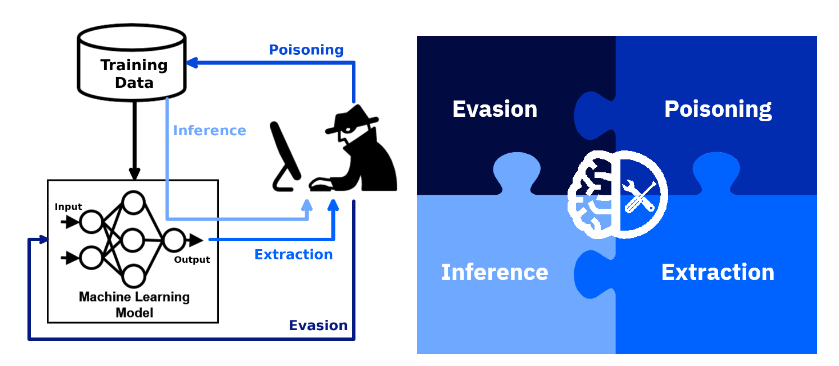

In [49]:
from IPython.display import Image

Image(filename='images/ART.png')

In [ ]:
def get_data(num_classes):
    x_train, y_train = load_iris(return_X_y=True)
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] *= 2
    x_train[:, 1][y_train == 2] *= 2
    x_train[:, 0][y_train == 0] -= 3
    x_train[:, 1][y_train == 2] -= 2
    
    x_train[:, 0] = (x_train[:, 0] - 4) / (9 - 4)
    x_train[:, 1] = (x_train[:, 1] - 1) / (6 - 1)
    
    return x_train, y_train

https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/art/attacks/poisoning/perturbations/image_perturbations.py

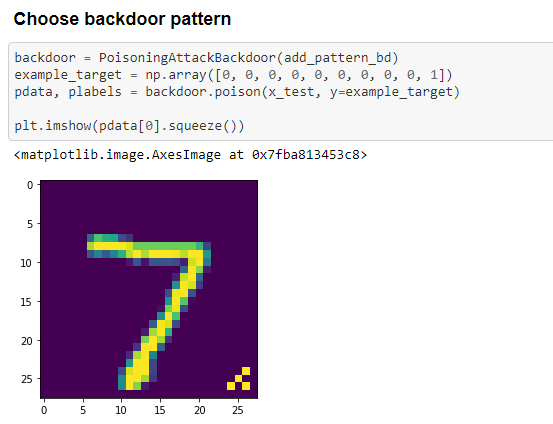

In [50]:
Image(filename='images/backdoor.png')